# Add cells to transcripts

In this notebook we will add the information from the cell segmentation to the transcripts.

With the MERSCOPE output we got a CSV called `detected_transcripts.csv` with the genes, x, y and z postitions. We will import that file and check for each transcript, if it is in a cell, as detected by `cellpose`

In [1]:
!head ../Merlin_output/detected_transcripts.csv | column -t -s, | cat

        barcode_id  global_x          global_y            global_z  x                   y                   fov  gene     transcript_id
76052   29          4811.93115234375  133.30604553222656  1.0       106.91827392578125  1234.315185546875   0    Ctcf     ENSMUST00000005841
578964  170         4873.68359375     128.1092987060547   3.0       678.7021484375      1186.197265625      0    Ets1     ENSMUST00000034534
663018  194         4963.92236328125  117.80232238769531  0.0       1514.2476806640625  1090.76220703125    0    Prdm1    ENSMUST00000039174
802336  241         4892.7421875      192.10520935058594  0.0       855.1704711914062   1778.7518310546875  0    Cxcr3    ENSMUST00000056614
805053  241         4972.5068359375   186.71917724609375  3.0       1593.7315673828125  1728.8812255859375  0    Cxcr3    ENSMUST00000056614
806807  241         4918.24951171875  195.59915161132812  5.0       1091.348388671875   1811.1031494140625  0    Cxcr3    ENSMUST00000056614
807957  242       

There are a few caveats to this. We need to adjust the scace / pixel ratio.  The information is stored in `micron_to_mosaic_pixel_transform.csv`, which is also found in the MERSCOPE output. There once again, is no good documentation about the file, but I assusme that the first two values are the scaling for x and y and the third is for z

In [2]:
!bat ../Merlin_output/images/micron_to_mosaic_pixel_transform.csv

───────┬────────────────────────────────────────────────────────────────────────
       │ File: ../Merlin_output/images/micron_to_mosaic_pixel_transform.csv
───────┼────────────────────────────────────────────────────────────────────────
   1   │ 9.259384155273437500e+00 0.000000000000000000e+00 -0.000000000000000000
       │ e+00
   2   │ 0.000000000000000000e+00 9.259361267089843750e+00 -0.000000000000000000
       │ e+00
   3   │ 0.000000000000000000e+00 0.000000000000000000e+00 1.000000000000000000e
       │ +00
───────┴────────────────────────────────────────────────────────────────────────


However, we need to keep in mind that we downsampled the image in order to run cellpose. We need to take that into account. We will calculte the scaling factors first.

In [3]:
# import the libraries
import tifffile
import pandas as pd
import numpy as np

In [4]:
# # the get the size of the original image, we can take any of the images
# # they are all the same size
# size_original_image = tifffile.imread("../Merlin_output/images/mosaic_Cellbound2_z0.tif").shape
# size_original_image

In [5]:
# # rescaled image
# size_rescaled_image = tifffile.imread("image/full_stack.tif").shape
# # since this is the stacked image, we dont need to keep all dimensions.
# size_rescaled_image = size_rescaled_image[2:4]
# size_rescaled_image

In [6]:
# mmpt = pd.read_csv(
#     "../Merlin_output/images/micron_to_mosaic_pixel_transform.csv", 
#     header=None, 
#     sep=' '
# )
# mmpt = np.array(mmpt)
# mmpt

There is obivously no documentation about the "transformation matrix" but but inspecting the values I assume the follwoing:
- The diagonal in the scaling.
- the values [0,2] and [1,2] are the offset?

In [7]:
# scale_y = size_original_image[0] / size_rescaled_image[0]
# scale_x = size_original_image[1] / size_rescaled_image[1]
# scale_y, scale_x

# rescale = np.array([scale_x, scale_y, 1])
# rescale

Now, that we have the scaling factors, we can import the transcripts table.

In [8]:
transcripts = pd.read_csv("../Merlin_output/detected_transcripts.csv")
transcripts

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id
0,76052,29,4811.931152,133.306046,1.0,106.918274,1234.315186,0,Ctcf,ENSMUST00000005841
1,578964,170,4873.683594,128.109299,3.0,678.702148,1186.197266,0,Ets1,ENSMUST00000034534
2,663018,194,4963.922363,117.802322,0.0,1514.247681,1090.762207,0,Prdm1,ENSMUST00000039174
3,802336,241,4892.742188,192.105209,0.0,855.170471,1778.751831,0,Cxcr3,ENSMUST00000056614
4,805053,241,4972.506836,186.719177,3.0,1593.731567,1728.881226,0,Cxcr3,ENSMUST00000056614
...,...,...,...,...,...,...,...,...,...,...
260479,724991,221,2836.630859,9747.528320,0.0,337.099091,1358.897705,1467,Cd74,ENSMUST00000050487
260480,977945,298,2926.006836,9729.467773,0.0,1164.655518,1191.672241,1467,Arnt,ENSMUST00000090804
260481,1454933,435,2815.286865,9769.478516,0.0,139.470963,1562.134277,1467,Aldh18a1,ENSMUST00000176939
260482,1577062,477,2966.376953,9744.248047,0.0,1538.451660,1328.524292,1467,Hmgcs1,ENSMUST00000224188


In [9]:
# diagnoal of the matrix for scaling
# np.diag(mmpt)

In [10]:
# third col for offset,
# but the dont want to add a value to the z axis...
# np.append(mmpt[0:2,2], 0)

Let's test if it works with a few selected rows

In [11]:
# from numpy.linalg import inv
# idx = np.arange(0,20)
# points = np.array([
#     transcripts.global_x[idx], 
#     transcripts.global_y[idx], 
#     transcripts.global_z[idx]]
# )
# points = np.round(np.diag(mmpt) * points.T + np.append(mmpt[0:2,2], 0)).astype(int)
# points

It seems to be working. So lets comment all the cells above and warp everyting into a function

In [12]:
def create_rescaling_function():
    """
    Here we create a rescaling function that takes three argument: x, y, z.
    These are the coordinates of out point. We will apply the transformation
    defined in 'micron_to_mosaic_pixel_transform' to convert the micron to pixel
    and then rescale it with the same scaling factor used in script '01'
    """
    # the get the size of the original image, we can take any of the images
    # they are all the same size
    size_original_image = tifffile.imread("../Merlin_output/images/mosaic_Cellbound2_z0.tif").shape
    
    # rescaled image
    size_rescaled_image = tifffile.imread("image/full_stack.tif").shape
    # since this is the stacked image, we dont need to keep all dimensions.
    size_rescaled_image = size_rescaled_image[2:4]
    
    scale_y = size_original_image[0] / size_rescaled_image[0]
    scale_x = size_original_image[1] / size_rescaled_image[1]
    rescale = np.array([scale_x, scale_y, 1])
    
    
    mmpt = pd.read_csv(
        "../Merlin_output/images/micron_to_mosaic_pixel_transform.csv", 
        header=None, 
        sep=' '
    )
    mmpt = np.array(mmpt)

    def rescale_fun(x,y,z):
        points = np.array([x,y,z])
        # coordinates to pixel
        points = np.diag(mmpt) * points.T + np.append(mmpt[0:2,2], 0)
        # apply our scaling
        points = points / rescale
        return(points.T)
    
    return(rescale_fun)
rescale_fun = create_rescaling_function()
rescale_fun

<function __main__.create_rescaling_function.<locals>.rescale_fun(x, y, z)>

In [13]:
points = rescale_fun(transcripts.global_x, transcripts.global_y, transcripts.global_z)
# round to integer that we can use it with the cell segmentation mask
points = np.round(points).astype(int)
points

array([[14852, 15042, 15321, ...,  8689,  9156,  8899],
       [  411,   395,   364, ..., 30153, 30075, 29967],
       [    1,     3,     0, ...,     0,     0,     0]])

As a quality contorl, we can plot the points in a 2D image (ignore the z position)

In [14]:
# load the image and define a plotting helper function
img = tifffile.imread("image/full_stack.tif")[3]
def make_image(img):
    """ Function to format the np array for plotting
    
    Takes a np array of dimensions (2 x Y x X) and
    formats it to Y x X x 3.
    Third color is filled with zeros.
    
    """
    
    # move the RGB to the third dimension
    img = np.transpose(img, [1,2,0])
    zeros = np.zeros(
                [img.shape[0], img.shape[1], 1],
                dtype = np.uint8
            )
   
    # fill R(ed) with zeros
    img = np.concatenate(
        [zeros,img],
        axis = 2,
        dtype = np.uint8
    )


    # scale the colors from 0 to 255 to make it more intense
    img[:,:,1] = np.uint8(np.round(img[:,:,1] / np.max(img[:,:,1]) * 350))
    img[:,:,2] = np.uint8(np.round(img[:,:,2] / np.max(img[:,:,2]) * 350))
    

    return(img)

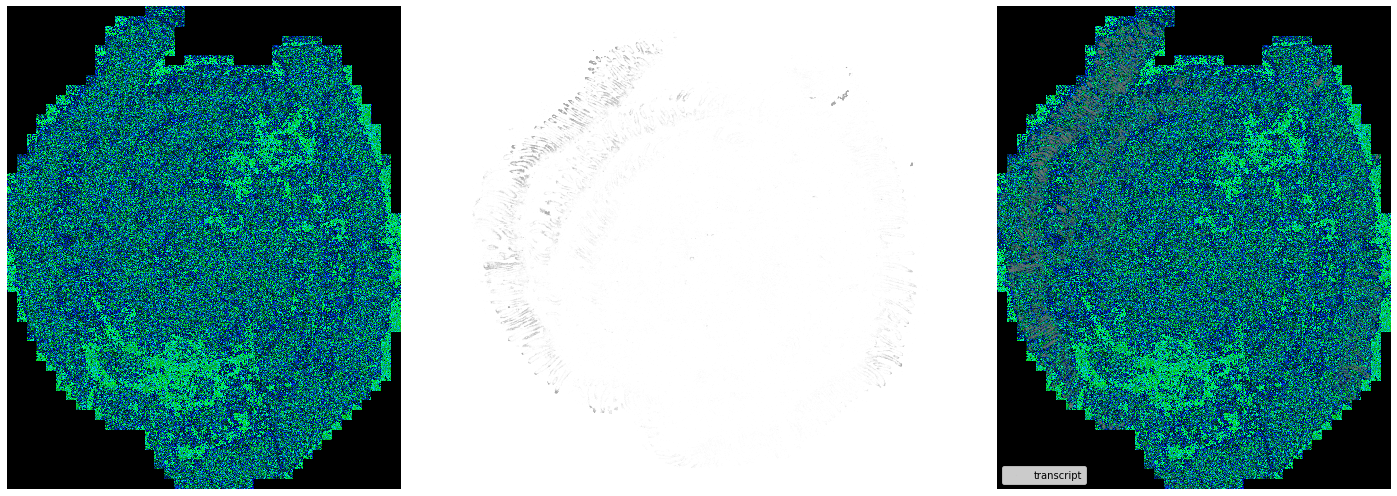

In [15]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (21,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# plot image
ax1.imshow(
    make_image(img),
    interpolation = "nearest",
    origin='lower'
)

ax2.scatter(points[0], points[1], s=.1, alpha=0.02, label = 'transcript', c='gray')

ax3.imshow(
    make_image(img),
    interpolation = "nearest",
    origin='lower'
)
ax3.scatter(points[0], points[1], s=.1, alpha=0.05, label = 'transcript', c='gray')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax3.legend(loc='lower left')

fig.tight_layout()

Next, we can import the segmentation mask from the previous script.

In [16]:
masks = np.load("cellpose_segmentation/masks.npy")

In [17]:
masks.shape

(7, 30315, 24759)

And we can add the dcellpose_segmentation/ted cell to the dataframe. We need to rearrange the points in z,y,x to match the order in the segmentation mask

In [18]:
transcripts['mask'] = masks[
  tuple(points[[2,1,0]])
]

In [19]:
transcripts

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,mask
0,76052,29,4811.931152,133.306046,1.0,106.918274,1234.315186,0,Ctcf,ENSMUST00000005841,4377
1,578964,170,4873.683594,128.109299,3.0,678.702148,1186.197266,0,Ets1,ENSMUST00000034534,0
2,663018,194,4963.922363,117.802322,0.0,1514.247681,1090.762207,0,Prdm1,ENSMUST00000039174,0
3,802336,241,4892.742188,192.105209,0.0,855.170471,1778.751831,0,Cxcr3,ENSMUST00000056614,0
4,805053,241,4972.506836,186.719177,3.0,1593.731567,1728.881226,0,Cxcr3,ENSMUST00000056614,0
...,...,...,...,...,...,...,...,...,...,...,...
260479,724991,221,2836.630859,9747.528320,0.0,337.099091,1358.897705,1467,Cd74,ENSMUST00000050487,0
260480,977945,298,2926.006836,9729.467773,0.0,1164.655518,1191.672241,1467,Arnt,ENSMUST00000090804,0
260481,1454933,435,2815.286865,9769.478516,0.0,139.470963,1562.134277,1467,Aldh18a1,ENSMUST00000176939,0
260482,1577062,477,2966.376953,9744.248047,0.0,1538.451660,1328.524292,1467,Hmgcs1,ENSMUST00000224188,0


Lets see how many transcripts are in a cell. 27 % are assigned. This is worse than the first MERSCOPE experiment that we did (44%). But the overall quality of that experiment was not great. so let's move on

In [20]:
np.sum(transcripts['mask'] > 0) / transcripts.shape[0]

0.2789461156923266

We can now save the new transcripts.csv file and use that as an input for baysor

In [21]:
transcripts.to_csv("cellpose_segmentation/transcripts.csv")

In [22]:
np.max(masks)

62516